In [1]:
from general_framework import *

# This framework is for recalling (reconstructing) images from between 1 and N elements ago
# The first 3 are probably stored in canvases (and that will be the first version); the others
# will require difficult reconstruction from memory.
#
# This is focused only on images for now. Text recollection may come, later.
# RAW. Needs calibration; may or may not work. THe 'context' tensor may need better markers for what comes from which input

N_lookback = 3 # just canvases for now
min_lookback = 0 

current_image_prompts = [\
    "Hey, recall the current image again?", \
    "Focus on the present view, please.", \
    "What do you see right now?", \
    "Think about the present game, for a moment."\
]

prev_image_prompts = [\
    "Hey, recall the last image, again?", \
    "Focus on the last view, please.", \
    "What did you see 1 image ago?", \
    "Think about the last game, for a moment.", \
    "Woah! What was that 1 image ago, again???" \
]

def get_image_prompts(ind):
    return [\
        f"Hey, could you recall the image {ind} ago, again?", \
        f"Focus on the view {ind} ago, please.", \
        f"Hey, recall the game {ind} ago for me, will you?", \
        f"Woah! What was that {ind} images ago, again??", \
        f"Think about the game from {ind} ago for me, will you?", \
        f"What did you see {ind} games ago, again.", \
        f"Think about the view {ind} steps ago, for a moment." \
    ]   

lookback_prompts = [current_image_prompts, prev_image_prompts]

for n in range(2, N_lookback):
    lookback_prompts.append(get_image_prompts(n))

lookback_prompts = lookback_prompts[min_lookback:N_lookback]

def mem_task_img_sample(num_sample=40):
    img_in = torch.zeros(num_sample, 224, 224, 3)
    for i in range(num_sample):
        bare_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)
        G2 = discreteGame(bare_settings)
        img_in[i] = torch.tensor(G2.getData())
    img_in = torch.permute(img_in, (0, 3, 1, 2)).contiguous().to(device)
    return img_in


pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [2]:
# newest to oldest, possible targets
def get_prompts(img_tensor_list):
    batch_size = img_tensor_list[0].size()[0]
    lookback_vals = np.random.randint(0, N_lookback - min_lookback, (batch_size,))

    target = torch.zeros_like(img_tensor_list[0])
    prompts = []

    for ind in range(batch_size):
        lookback = lookback_vals[ind]
        target[ind] = img_tensor_list[lookback][ind].detach()
        prompts.append(random.choice(lookback_prompts[lookback + min_lookback]))

    target = target.contiguous()

    prompt_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(prompts)]).contiguous().to(device)
    padded_prompt_tensor = torch.zeros((batch_size, 32), dtype=prompt_tensor.dtype, device=prompt_tensor.device)
    padded_prompt_tensor[:, :prompt_tensor.size()[1]] += prompt_tensor
    return padded_prompt_tensor, target



In [3]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

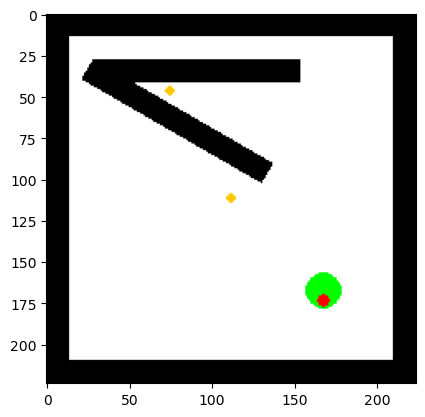

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [6]:
batch_size = 8
batch_num = 12 # why not?

In [7]:
lookback_prompts[2]

['Hey, could you recall the image 2 ago, again?',
 'Focus on the view 2 ago, please.',
 'Hey, recall the game 2 ago for me, will you?',
 'Woah! What was that 2 images ago, again??',
 'Think about the game from 2 ago for me, will you?',
 'What did you see 2 games ago, again.',
 'Think about the view 2 steps ago, for a moment.']

In [8]:
lookback_prompts[0]

['Hey, recall the current image again?',
 'Focus on the present view, please.',
 'What do you see right now?',
 'Think about the present game, for a moment.']

In [9]:
lookback_prompts[1]

['Hey, recall the last image, again?',
 'Focus on the last view, please.',
 'What did you see 1 image ago?',
 'Think about the last game, for a moment.',
 'Woah! What was that 1 image ago, again???']

In [10]:
ind = (batch_num * batch_size) % num_controls
if ind + batch_size > num_controls:
    ind = num_controls - batch_size
control_texts = sdt[ind:ind + batch_size].to(device)

In [11]:
tokenizer.decode(control_texts[0].detach().cpu().numpy())

'<s>You are saying you intentionally hide your good looks?</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

In [12]:
# perfect

In [13]:
def quick_str(text_tensor):
    if len(text_tensor.size()) > 1:
        text_tensor = text_tensor[0]
    return tokenizer.decode(text_tensor.detach().cpu().numpy())

In [14]:
img_tensor_list = []
prompt_tensor_list = []

In [15]:
min_lookback

0

In [16]:
N_lookback

3

In [17]:
for step in range(N_lookback):
    imgs = mem_task_img_sample(batch_size)
    img_tensor_list.append(imgs)
    if step == N_lookback - 1:
        L = img_tensor_list[min_lookback:]
        L.reverse() # img_tensor_list should be unharmed by this
        prompt_tensor, target = get_prompts(L)
        prompt_tensor_list.append(prompt_tensor)
    else:
        prompt_tensor_list.append(control_texts)

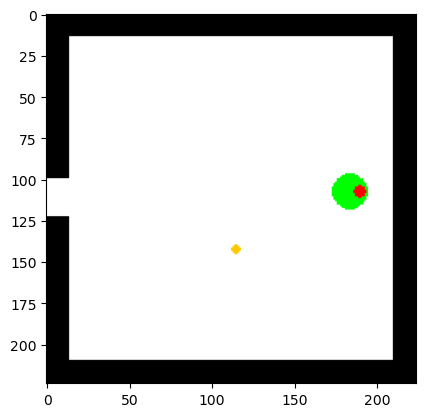

In [18]:
quick_display(img_tensor_list[0][2])

In [19]:
quick_str(prompt_tensor_list[0][2])

"<s>If anyone was to ask what the point of the story is, I really don't know.</s><s><s><s><s><s><s><s><s><s><s><s>"

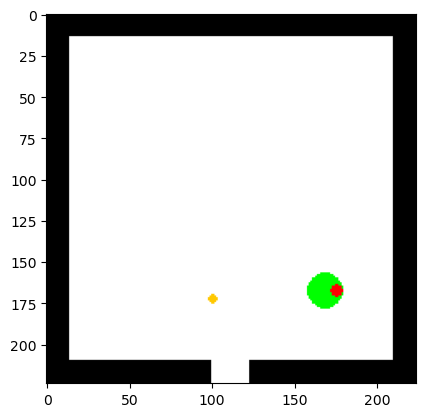

In [20]:
quick_display(img_tensor_list[1][2])

In [21]:
quick_str(prompt_tensor_list[1][2])

"<s>If anyone was to ask what the point of the story is, I really don't know.</s><s><s><s><s><s><s><s><s><s><s><s>"

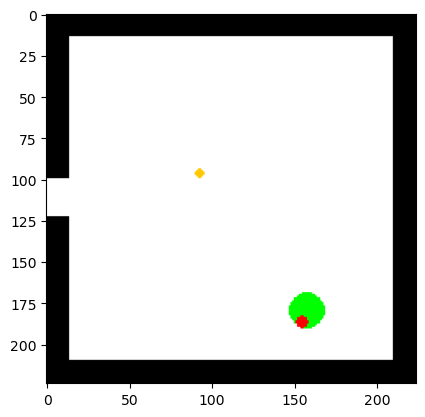

In [22]:
quick_display(img_tensor_list[2][2])

In [23]:
quick_str(prompt_tensor_list[2][2])

'<s>Hey, recall the last image, again?</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

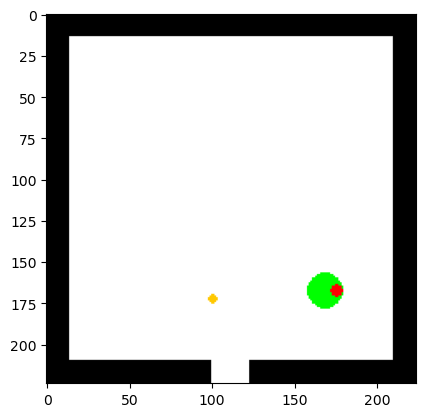

In [24]:
quick_display(target[2])

In [25]:
# ok, no glaring errors. Good.

In [26]:
model = EnhancedAgentBrain()
model.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.
#fname = 'brain_checkpoints/enhanced_brain_first_training_v2_batch160799.pth'
#fname = 'brain_checkpoints/enhanced_brain_control_training_v2_batch55900.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v2_batch24800.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v3_batch155466.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v4_batch399.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v5_batch133.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v2_batch29398.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v3_batch35249.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_de_novo_v1_batch41200.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_v1_batch33400.pth'
#fname = 'brain_checkpoints/frankenstein_transferred.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_RESTART_v1_batch31799.pth'
fname = 'brain_checkpoints/frankenstein_canvases_v1_batch33597.pth'

# A little extra code to avoid weird error
#model.memory.remember(torch.randn(16, 1, 768).to(device))
#model.memory.remember(torch.randn(8, 1, 768).to(device))

model.load_state_dict(torch.load(fname, weights_only=True, map_location=device))
model.reset()

In [27]:
for step in range(N_lookback):
    if step < N_lookback - 2:
        print('a')
        _ = model(prompt_tensor_list[step], img_tensor_list[step], ret_imgs=False)
    elif step == N_lookback - 2:
        print('b')
        control_probs, control_recon = model(prompt_tensor_list[step], img_tensor_list[step], ret_imgs=True)
    else: # if step == N_lookback - 1
        print('c')
        text_probs, recon = model(prompt_tensor_list[step], img_tensor_list[step], ret_imgs=True)

a
img_weights:

tensor([[[9.9644e-01],
         [6.6517e-04],
         [2.5512e-04],
         [2.6363e-03]],

        [[9.9555e-01],
         [2.2151e-03],
         [7.1291e-04],
         [1.5248e-03]],

        [[9.9887e-01],
         [2.9631e-04],
         [1.7754e-04],
         [6.5770e-04]],

        [[9.9421e-01],
         [9.5898e-04],
         [5.9323e-04],
         [4.2334e-03]],

        [[9.9781e-01],
         [2.9041e-04],
         [1.9958e-04],
         [1.7041e-03]],

        [[9.9559e-01],
         [1.6677e-03],
         [7.3919e-04],
         [2.0056e-03]],

        [[9.9023e-01],
         [2.2919e-03],
         [2.6589e-03],
         [4.8199e-03]],

        [[9.9654e-01],
         [5.6663e-04],
         [5.6880e-04],
         [2.3289e-03]]], device='cuda:1', grad_fn=<SoftmaxBackward0>)
b


/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


img_weights:

tensor([[[9.8748e-01],
         [3.8516e-03],
         [1.6680e-03],
         [7.0044e-03]],

        [[9.9726e-01],
         [7.3744e-04],
         [2.6922e-04],
         [1.7304e-03]],

        [[9.9426e-01],
         [2.1190e-03],
         [9.1516e-04],
         [2.7024e-03]],

        [[9.9806e-01],
         [5.1661e-04],
         [4.0450e-04],
         [1.0228e-03]],

        [[9.9665e-01],
         [9.8221e-04],
         [3.0870e-04],
         [2.0579e-03]],

        [[9.9531e-01],
         [1.3086e-03],
         [6.7836e-04],
         [2.7017e-03]],

        [[9.9036e-01],
         [1.9881e-03],
         [1.2744e-03],
         [6.3776e-03]],

        [[9.9809e-01],
         [4.8987e-04],
         [2.5448e-04],
         [1.1622e-03]]], device='cuda:1', grad_fn=<SoftmaxBackward0>)
c
img_weights:

tensor([[[9.9075e-01],
         [1.5672e-03],
         [1.3911e-03],
         [6.2923e-03]],

        [[3.8863e-02],
         [2.8307e-05],
         [3.0191e-03],
         [

In [36]:
quick_str(prompt_tensor_list[2][5])

'<s>Think about the view 2 steps ago, for a moment.</s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21072221..1.2347691].


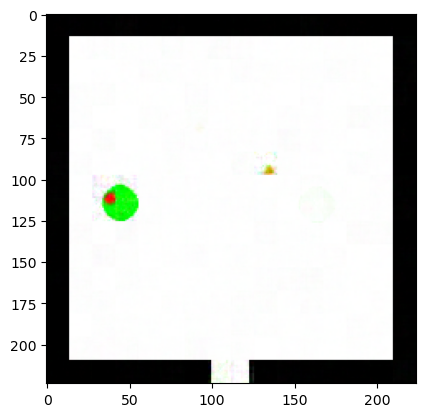

In [37]:
quick_display(recon[5])

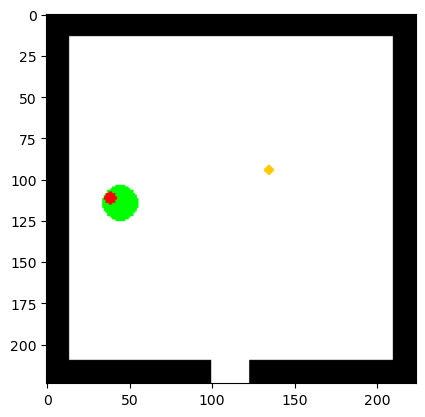

In [38]:
quick_display(target[5])